# Image Generation with VAEs and GANs on the Quick, Draw! Dataset

This project delves into the field of generative deep learning, focusing on two prominent model architectures: Variational Autoencoders (VAEs) and Generative Adversarial Networks (GANs). The capabilities of these models are explored in generating novel images, using the unique and diverse Quick, Draw! dataset as a training ground.

## Overview

Two powerful generative models are implemented and compared:

*   **Variational Autoencoders (VAEs):** VAEs represent a probabilistic approach to autoencoders. They learn a compressed, latent representation of input data by mapping it to a probability distribution (typically a Gaussian). Sampling from this learned latent space and passing the samples through a decoder network enables VAEs to generate new, synthetic data points.
*   **Generative Adversarial Networks (GANs):** GANs employ an adversarial training process, where a generator network learns to create realistic data samples from random noise, and a discriminator network learns to distinguish between real data and the generator's creations. This competitive process drives both networks to improve, ultimately leading to a generator capable of producing highly realistic outputs.

## Dataset

The project utilizes the **Quick, Draw! dataset**, a collection of 50 million simple drawings created by players of the online game "Quick, Draw!". This dataset encompasses 345 different categories, providing a wide range of visual concepts. This project specifically focuses on:

*   **Image Format:** 28x28 grayscale images.
*   **Selected Classes:** Five distinct classes are chosen for image generation: cat, dog, bird, tree, and house.
*   **Sample Size:** 20,000 images per class are used for training (with experimentation using sample sizes from 15,000 to 500,000).

## Model Architecture and Training

Both the VAE and GAN models are implemented using the PyTorch deep learning framework. The training process is accelerated by leveraging the power of GPU computation through either Apple's Metal Performance Shaders (MPS) framework on Apple silicon (for the GAN) or CUDA on an NVIDIA T4 GPU on Google Colab (for the VAE).

The models share the following key hyperparameters:

*   **Latent Dimension:** 128 (with experimentation using 32, 64, and 256 to explore the impact of latent space dimensionality).
*   **Batch Size:** 64 (with experimentation using 32, 64, 128, 256, 512, and 1024 to optimize training efficiency).
*   **Training Epochs:** 50. Early stopping is implemented to prevent overfitting and optimize training time.

The core objective of the training process is to enable the models to:

1. **Encode:** Map input drawings from the Quick, Draw! dataset into a compressed latent space representation that captures the essential features of each class.
2. **Generate:** Produce new, plausible drawings by sampling from the learned latent space (for VAEs) or from random noise (for GANs).
3. **Synthesize:** Generate realistic synthetic drawings that exhibit the characteristic features and diversity of the training data.

# Environment Setup

This project is compatible with Python 3.9. The necessary packages can be installed using pip.

In [1]:
%pip install -r requirements.txt

Note: you may need to restart the kernel to use updated packages.


In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
import numpy as np
import matplotlib.pyplot as plt
import time

# --- Constants ---
IMAGE_SIZE = 28       # Height and width of the images
CHANNELS = 1          # Number of channels in the images (grayscale)
BATCH_SIZE = 64       # Batch size for training
LATENT_DIM_GAN = 128  # Dimension of the random noise vector for the generator
EPOCHS = 50           # Number of training epochs (you might need more)
CLASSES = ['cat', 'dog', 'bird', 'tree', 'house']  # Chosen classes
DATA_DIR = "quickdraw_data"  # Directory to store the data
MAX_ITEMS_PER_CLASS = 5000 # Limit the number of samples per class - this number is changed between different expriments

# --- Check for CUDA (GPU support) ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cpu


**Setting Random Seeds for Reproducibility**: 

42 is a common choice (it's the "Answer to the Ultimate Question of Life, the Universe, and Everything" from The Hitchhiker's Guide to the Galaxy). The important thing is to use the same seed consistently to get the same results.

In [ ]:
# --- Set random seed for reproducibility ---
torch.manual_seed(42)
np.random.seed(42)

# Data Download and Preparation:

- **Class Selection**: Choose your five classes: cat, dog, bird, tree, house.

- **Download**: Use the provided download_quickdraw_data function (from the "Data Loading and Preparation" section) to download the .npy files for the chosen classes. This function efficiently checks if the files already exist locally.

- **Load Data**: Use the load_quickdraw_data function to load the data into memory.

In [19]:
# --- Data Loading and Preparation ---
import os
import urllib.request
from tqdm import tqdm

def download_quickdraw_data(classes, base_url="https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/"):
    """Downloads Quick, Draw! data if not already present."""
    for class_name in classes:
        file_name = f"{class_name.replace(' ', '_')}.npy"
        file_path = os.path.join(DATA_DIR, file_name)
        if not os.path.exists(file_path):
            print(f"Downloading {file_name}...")
            with tqdm(unit="B", unit_scale=True, unit_divisor=1024, miniters=1) as t:
                urllib.request.urlretrieve(base_url + file_name, file_path, reporthook=lambda b, bsize, tsize: t.update(bsize))
        else:
            print(f"{file_name} already downloaded.")

def load_quickdraw_data(classes, max_items_per_class, data_dir=DATA_DIR):
    """Loads Quick, Draw! data into memory."""
    all_data = []
    all_labels = []
    for idx, class_name in enumerate(classes):
        file_name = f"{class_name.replace(' ', '_')}.npy"
        file_path = os.path.join(data_dir, file_name)
        try:
            data = np.load(file_path)
            if data.shape[0] > max_items_per_class:
                data = data[:max_items_per_class]
            all_data.append(data)
            all_labels.append(np.full((data.shape[0],), idx))
        except FileNotFoundError:
            print(f"Error: File not found: {file_path}")
            print("Please ensure the data has been downloaded correctly.")
            return None, None

    return np.concatenate(all_data), np.concatenate(all_labels)

# Download and load data
download_quickdraw_data(CLASSES)
x_data, labels = load_quickdraw_data(CLASSES, MAX_ITEMS_PER_CLASS)

# Reshape and normalize data
x_data = x_data.reshape(-1, 1, 28, 28).astype('float32') / 255.

# Split into training and testing sets
num_samples = len(x_data)
train_size = int(0.8 * num_samples)
x_train, x_test = x_data[:train_size], x_data[train_size:]
y_train, y_test = labels[:train_size], labels[train_size:]

# Convert to PyTorch tensors
x_train = torch.from_numpy(x_train).float()
x_test = torch.from_numpy(x_test).float()
y_train = torch.from_numpy(y_train).long()  # Use long for class labels
y_test = torch.from_numpy(y_test).long()

# Create TensorDatasets and DataLoaders
train_dataset = TensorDataset(x_train, y_train)
test_dataset = TensorDataset(x_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

# Print shapes
print("x_train shape:", x_train.shape)
print("y_train shape:", y_train.shape)
print("x_test shape:", x_test.shape)
print("y_test shape:", y_test.shape)

cat.npy already downloaded.
dog.npy already downloaded.
bird.npy already downloaded.
tree.npy already downloaded.
house.npy already downloaded.
x_train shape: torch.Size([400000, 1, 28, 28])
y_train shape: torch.Size([400000])
x_test shape: torch.Size([100000, 1, 28, 28])
y_test shape: torch.Size([100000])


# VAE Building & Training

> To expedite the training process, an NVIDIA T4 GPU was utilized via the Google Colab platform.

In [95]:
import tensorflow as tf
from tensorflow import keras
from keras import layers

# Định nghĩa lớp Sampling
class Sampling(layers.Layer):
    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.random.normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon
    
# Xây dựng encoder
def build_encoder(latent_dim):
    encoder_inputs = keras.Input(shape=(28, 28, 1))
    x = layers.Conv2D(32, 3, activation="relu", strides=2, padding="same")(encoder_inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(64, 3, activation="relu", strides=2, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(128, 3, activation="relu", strides=1, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Flatten()(x)
    x = layers.Dense(32, activation="relu")(x)
    x = layers.BatchNormalization()(x)
    
    z_mean = layers.Dense(latent_dim, name="z_mean")(x)
    z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
    
    return keras.Model(encoder_inputs, [z_mean, z_log_var], name="encoder")

# Xây dựng decoder
def build_decoder(latent_dim):
    latent_inputs = keras.Input(shape=(latent_dim,))
    x = layers.Dense(7 * 7 * 128, activation="relu")(latent_inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Reshape((7, 7, 128))(x)
    
    x = layers.Conv2DTranspose(128, 3, activation="relu", strides=1, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2DTranspose(64, 3, activation="relu", strides=2, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2DTranspose(32, 3, activation="relu", strides=2, padding="same")(x)
    x = layers.BatchNormalization()(x)
    
    decoder_outputs = layers.Conv2DTranspose(1, 3, activation="sigmoid", padding="same")(x)
    
    return keras.Model(latent_inputs, decoder_outputs, name="decoder")

# Định nghĩa VAE model
class VAE(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super().__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.sampling = Sampling()
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(name="reconstruction_loss")
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]

    def get_config(self):
        config = super().get_config()
        config.update({
            "encoder": self.encoder.get_config(),
            "decoder": self.decoder.get_config(),
        })
        return config

    @classmethod
    def from_config(cls, config):
        encoder = keras.Model.from_config(config.pop("encoder"))
        decoder = keras.Model.from_config(config.pop("decoder"))
        return cls(encoder=encoder, decoder=decoder, **config)

    def train_step(self, data):
        with tf.GradientTape() as tape:
            z_mean, z_log_var = self.encoder(data)
            z = self.sampling([z_mean, z_log_var])
            reconstruction = self.decoder(z)
            
            reconstruction_loss = tf.reduce_mean(
                tf.reduce_sum(
                    keras.losses.binary_crossentropy(data, reconstruction),
                    axis=(1, 2)
                )
            )
            kl_loss = -0.5 * tf.reduce_mean(
                1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var)
            )
            total_loss = reconstruction_loss + kl_loss

        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }

# Khởi tạo model
latent_dim = 128
encoder = build_encoder(latent_dim)
decoder = build_decoder(latent_dim)
vae = VAE(encoder, decoder)

# Compile và train
vae.compile(optimizer=keras.optimizers.Adam())

### Training

In [96]:
# Training
# Định nghĩa training loop thay vì dùng fit()
@tf.function
def train_step(model, x, optimizer):
    with tf.GradientTape() as tape:
        z_mean, z_log_var = model.encoder(x)
        z = model.sampling([z_mean, z_log_var])
        reconstruction = model.decoder(z)
        
        reconstruction_loss = tf.reduce_mean(
            tf.reduce_sum(
                keras.losses.binary_crossentropy(x, reconstruction),
                axis=(1, 2)
            )
        )
        kl_loss = -0.5 * tf.reduce_mean(
            1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var)
        )
        total_loss = reconstruction_loss + kl_loss

    grads = tape.gradient(total_loss, model.trainable_weights)
    optimizer.apply_gradients(zip(grads, model.trainable_weights))
    
    return total_loss, reconstruction_loss, kl_loss

# Training loop
optimizer = keras.optimizers.Adam()
epochs = 5
batch_size = 64

for epoch in range(epochs):
    print(f"\nEpoch {epoch + 1}/{epochs}")
    
    # Training
    n_batches = len(x_train) // batch_size
    total_loss_avg = tf.keras.metrics.Mean()
    reconstruction_loss_avg = tf.keras.metrics.Mean()
    kl_loss_avg = tf.keras.metrics.Mean()
    
    for batch in range(n_batches):
        start_idx = batch * batch_size
        end_idx = start_idx + batch_size
        x_batch = x_train[start_idx:end_idx]
        
        total_loss, reconstruction_loss, kl_loss = train_step(vae, x_batch, optimizer)
        
        total_loss_avg.update_state(total_loss)
        reconstruction_loss_avg.update_state(reconstruction_loss)
        kl_loss_avg.update_state(kl_loss)
        
        if batch % 100 == 0:
            print(f"Batch {batch}/{n_batches} - "
                  f"Loss: {total_loss_avg.result():.4f}, "
                  f"Reconstruction Loss: {reconstruction_loss_avg.result():.4f}, "
                  f"KL Loss: {kl_loss_avg.result():.4f}")


Epoch 1/5
Batch 0/312 - Loss: 537.9321, Reconstruction Loss: 537.9321, KL Loss: 0.0000
Batch 100/312 - Loss: 25.1109, Reconstruction Loss: 24.7793, KL Loss: 0.3317
Batch 200/312 - Loss: 12.6226, Reconstruction Loss: 12.4543, KL Loss: 0.1683
Batch 300/312 - Loss: 8.4312, Reconstruction Loss: 8.3181, KL Loss: 0.1131

Epoch 2/5
Batch 0/312 - Loss: 0.0040, Reconstruction Loss: 0.0028, KL Loss: 0.0011
Batch 100/312 - Loss: 0.0044, Reconstruction Loss: 0.0034, KL Loss: 0.0009
Batch 200/312 - Loss: 0.0037, Reconstruction Loss: 0.0029, KL Loss: 0.0007
Batch 300/312 - Loss: 0.0032, Reconstruction Loss: 0.0026, KL Loss: 0.0006

Epoch 3/5
Batch 0/312 - Loss: 0.0019, Reconstruction Loss: 0.0016, KL Loss: 0.0003
Batch 100/312 - Loss: 0.0020, Reconstruction Loss: 0.0017, KL Loss: 0.0003
Batch 200/312 - Loss: 0.0018, Reconstruction Loss: 0.0016, KL Loss: 0.0003
Batch 300/312 - Loss: 0.0017, Reconstruction Loss: 0.0014, KL Loss: 0.0003

Epoch 4/5
Batch 0/312 - Loss: 0.0014, Reconstruction Loss: 0.001

In [97]:
vae.save("trained_vae_model_5epoches.h5")

Generated images:


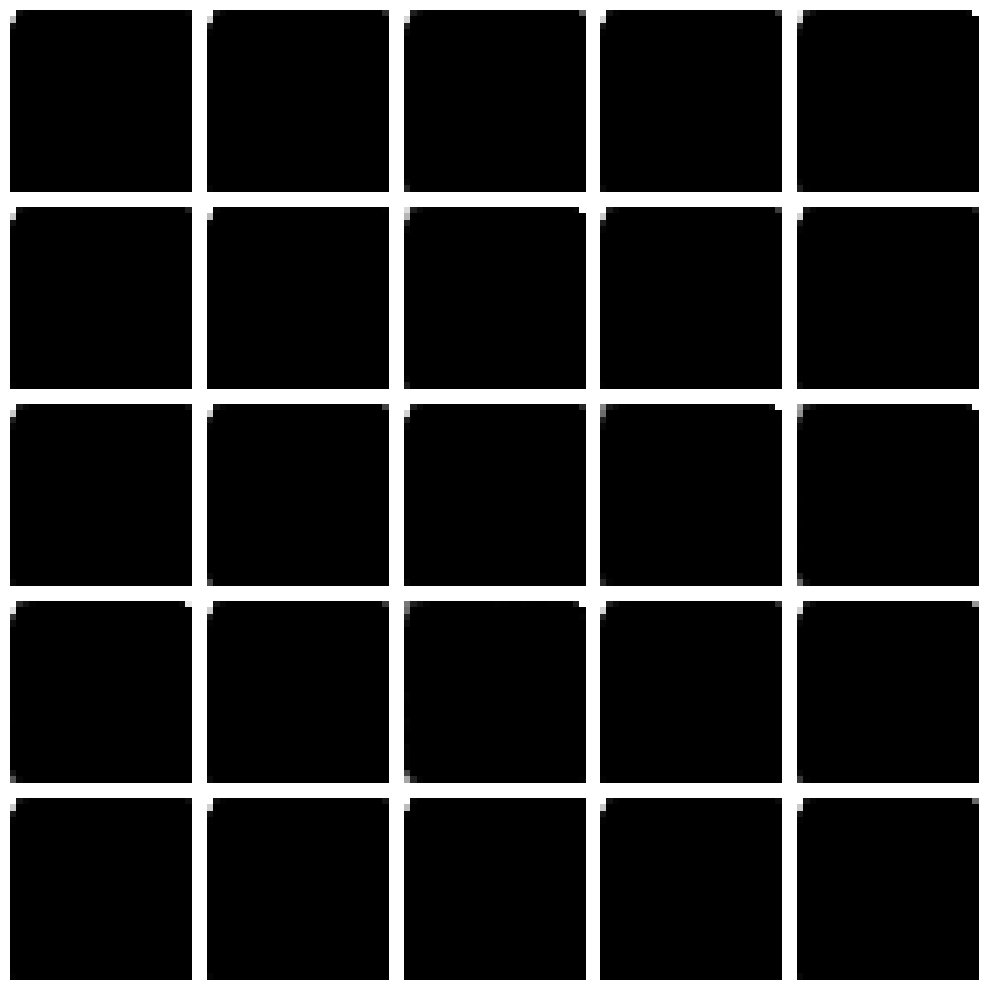


Original vs Reconstructed images:


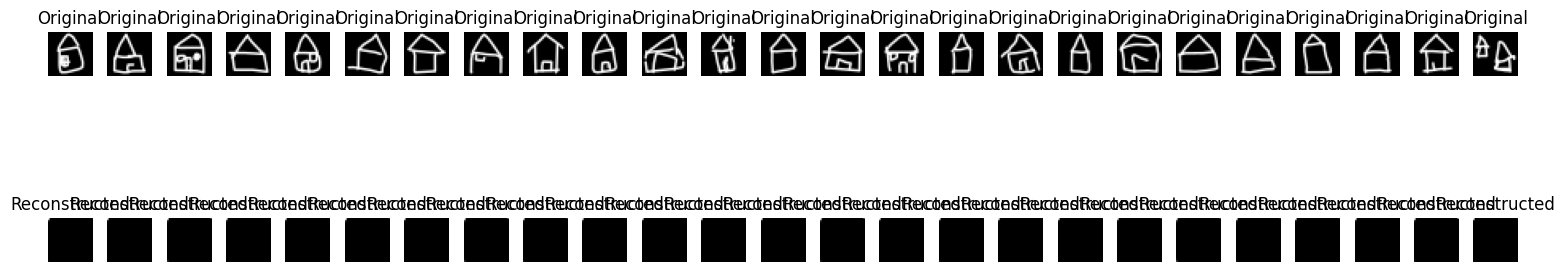


Pixel value ranges for generated images:
Min pixel value: 0.0
Max pixel value: 0.00019628011796157807
Mean pixel value: 1.592021163787649e-07


In [ ]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt

# Load the saved VAE model
new_vae = keras.models.load_model('trained_vae_model_5epoches.h5', 
                            custom_objects={'VAE': VAE})

def plot_generated_images(model, n=5):
    # Generate random latent vectors
    random_latent_points = tf.random.normal(shape=(n * n, LATENT_DIM))
    
    # Decode them to images
    generated_images = model.decoder(random_latent_points)
    
    # Rescale images 0 - 1
    generated_images = generated_images.numpy()
    
    # Plot images
    plt.figure(figsize=(10, 10))
    for i in range(n * n):
        plt.subplot(n, n, i + 1)
        plt.imshow(generated_images[i, :, :, 0], cmap='gray')
        plt.axis('off')
    plt.tight_layout()
    plt.show()

def plot_reconstructed_images(model, x_test, n=5):
    # Select test images
    test_images = x_test[:n*n]
    
    # Encode and decode images
    encoded = model.encoder(test_images)
    z = model.sampling(encoded)
    reconstructed_images = model.decoder(z)
    
    # Plot original and reconstructed images
    plt.figure(figsize=(15, 5))
    
    # Plot original images
    for i in range(n * n):
        plt.subplot(2, n*n, i + 1)
        plt.imshow(test_images[i, :, :, 0], cmap='gray')
        plt.title('Original')
        plt.axis('off')
        
    # Plot reconstructed images  
    for i in range(n * n):
        plt.subplot(2, n*n, i + n*n + 1)
        plt.imshow(reconstructed_images[i, :, :, 0], cmap='gray')
        plt.title('Reconstructed')
        plt.axis('off')
        
    plt.tight_layout()
    plt.show()

# Generate new images
print("Generated images:")
plot_generated_images(new_vae)

# Compare original vs reconstructed
print("\nOriginal vs Reconstructed images:")
plot_reconstructed_images(new_vae, x_test)

# Check pixel value ranges
def check_pixel_ranges(images):
    print(f"Min pixel value: {images.numpy().min()}")
    print(f"Max pixel value: {images.numpy().max()}")
    print(f"Mean pixel value: {images.numpy().mean()}")

# Generate some images and check their pixel ranges
random_latent_points = tf.random.normal(shape=(10, LATENT_DIM))
generated_images = new_vae.decoder(random_latent_points)
print("\nPixel value ranges for generated images:")
check_pixel_ranges(generated_images)


# GAN Training

In this training, the train computer cấu hình:
1. Macbook Air M1 with Apple Silicon -> using mps device to use GPU
2. Python 3.9.21

### GAN model

In [6]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import time
import os
import urllib.request
from tqdm import tqdm

# Constants
IMAGE_SIZE = 28
CHANNELS = 1
BATCH_SIZE = 256
LATENT_DIM = 128
LATENT_DIM_GAN = 64
EPOCHS = 1000
CLASSES = ['cat', 'dog', 'bird', 'tree', 'house']
DATA_DIR = "quickdraw_data"
MAX_ITEMS_PER_CLASS = 100000
IMAGE_SAVE_DIR = "gan/image/v1_4"

# Set random seed
torch.manual_seed(42)
np.random.seed(42)

In [7]:
def download_quickdraw_data(classes, base_url="https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/"):
    os.makedirs(DATA_DIR, exist_ok=True)
    for class_name in classes:
        file_name = f"{class_name.replace(' ', '_')}.npy"
        file_path = os.path.join(DATA_DIR, file_name)
        if not os.path.exists(file_path):
            print(f"Downloading {file_name}...")
            with tqdm(unit="B", unit_scale=True, unit_divisor=1024, miniters=1) as t:
                urllib.request.urlretrieve(base_url + file_name, file_path, 
                    reporthook=lambda b, bsize, tsize: t.update(bsize))
        else:
            print(f"{file_name} already downloaded.")

def load_quickdraw_data(classes, max_items_per_class, data_dir=DATA_DIR):
    all_data = []
    all_labels = []
    for idx, class_name in enumerate(classes):
        file_name = f"{class_name.replace(' ', '_')}.npy"
        file_path = os.path.join(data_dir, file_name)
        try:
            data = np.load(file_path)
            if data.shape[0] > max_items_per_class:
                data = data[:max_items_per_class]
            all_data.append(data)
            all_labels.append(np.full((data.shape[0],), idx))
        except FileNotFoundError:
            print(f"Error: File not found: {file_path}")
            return None, None
    return np.concatenate(all_data), np.concatenate(all_labels)

**Generate and Save Images Function**
- Generating sample images from random noise at regular intervals during training
- Providing a chronological record of how image generation improves across epochs

In [8]:
def generate_and_save_images(generator, epoch, batch_idx, noise, save_dir):
    """Generates and saves images from the generator with larger size and higher quality."""
    os.makedirs(save_dir, exist_ok=True)

    with torch.no_grad():
        fake_images = generator(noise).detach().cpu()
        
        # Rescale images from [-1, 1] to [0, 1]
        fake_images = 0.5 * fake_images + 0.5

        # Save image grid with large size
        fig = plt.figure(figsize=(10, 10))
        for i in range(fake_images.size(0)):
            plt.subplot(4, 4, i + 1)  # 4x4 grid for 16 images
            plt.imshow(fake_images[i, 0, :, :], cmap='gray')
            plt.axis('off')

        plt.tight_layout()
        plt.savefig(
            f"{save_dir}/epoch_{epoch}_batch_{batch_idx}.png",
            dpi=300,  # Increase resolution
            bbox_inches='tight',
            pad_inches=0.1
        )
        plt.close(fig)

In [9]:
class EarlyStopping:
    def __init__(self, patience=7, min_delta=0.001, verbose=True):
        self.patience = patience
        self.min_delta = min_delta
        self.verbose = verbose
        self.counter = 0
        self.best_g_loss = float('inf')
        self.best_d_loss = float('inf')
        self.early_stop = False
        
    def __call__(self, g_loss, d_loss):
        improved = False
        if g_loss < self.best_g_loss - self.min_delta:
            self.best_g_loss = g_loss
            improved = True
        if d_loss < self.best_d_loss - self.min_delta:
            self.best_d_loss = d_loss
            improved = True
        if not improved:
            self.counter += 1
            if self.verbose:
                print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.counter = 0

**Device Setup for M1 Macbook Air 2020 (Apple Silicon)**:

Using Metal Performance Shaders (MPS) backend for GPU acceleration on M1 Mac:

In [10]:
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
print(f"Using device: {device}")

Using device: mps


In [11]:
class Generator(nn.Module):
    def __init__(self, latent_dim=128):
        super(Generator, self).__init__()
        self.linear = nn.Sequential(
            nn.Linear(latent_dim, 7 * 7 * 256),
            nn.LeakyReLU(0.2)
        )
        self.conv_layers = nn.Sequential(
            nn.ConvTranspose2d(256, 128, 4, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2),
            nn.ConvTranspose2d(128, 64, 4, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2),
            nn.Conv2d(64, 1, 3, stride=1, padding=1),
            nn.Tanh()
        )

    def forward(self, z):
        x = self.linear(z)
        x = x.view(-1, 256, 7, 7)
        img = self.conv_layers(x)
        return img

In [12]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Conv2d(1, 64, 3, stride=2, padding=1),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.Conv2d(64, 128, 3, stride=2, padding=1),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.Flatten(),
            nn.Linear(7 * 7 * 128, 1),
            nn.Sigmoid()
        )

    def forward(self, img):
        validity = self.model(img)
        return validity

Epoch [0/1000] Batch [0/1563] D_loss: 1.3902 G_loss: 0.6990
Epoch [0/1000] Batch [100/1563] D_loss: 1.3172 G_loss: 0.7025
Epoch [0/1000] Batch [200/1563] D_loss: 1.3413 G_loss: 0.7268
Epoch [0/1000] Batch [300/1563] D_loss: 1.1884 G_loss: 0.8380
Epoch [0/1000] Batch [400/1563] D_loss: 1.0257 G_loss: 0.9524
Epoch [0/1000] Batch [500/1563] D_loss: 0.9709 G_loss: 1.2996
Epoch [0/1000] Batch [600/1563] D_loss: 0.8381 G_loss: 1.2482
Epoch [0/1000] Batch [700/1563] D_loss: 0.7265 G_loss: 1.4778
Epoch [0/1000] Batch [800/1563] D_loss: 0.7899 G_loss: 1.2187
Epoch [0/1000] Batch [900/1563] D_loss: 0.6922 G_loss: 1.8963
Epoch [0/1000] Batch [1000/1563] D_loss: 0.7095 G_loss: 1.3225
Epoch [0/1000] Batch [1100/1563] D_loss: 0.7776 G_loss: 1.8999
Epoch [0/1000] Batch [1200/1563] D_loss: 0.7489 G_loss: 2.1431
Epoch [0/1000] Batch [1300/1563] D_loss: 0.5498 G_loss: 1.7522
Epoch [0/1000] Batch [1400/1563] D_loss: 0.5736 G_loss: 1.6354
Epoch [0/1000] Batch [1500/1563] D_loss: 0.7408 G_loss: 1.8193
Epoc

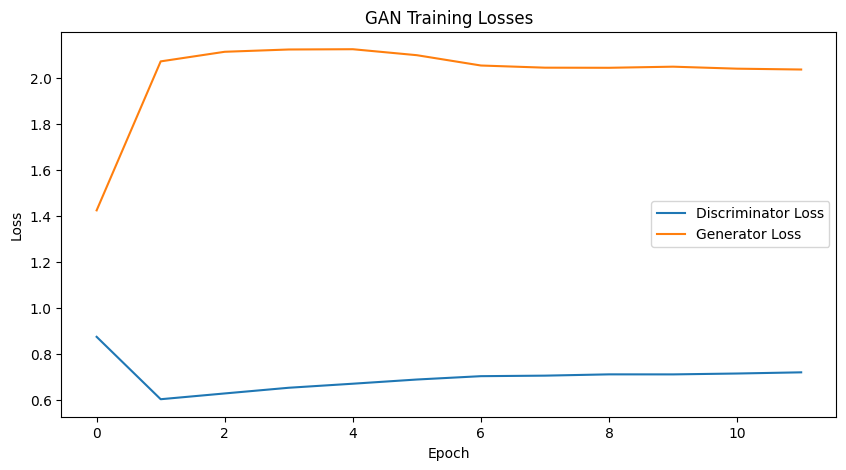

In [31]:
# Download and load data
x_data, labels = load_quickdraw_data(CLASSES, MAX_ITEMS_PER_CLASS)

if x_data is not None and labels is not None:
    # Prepare data
    x_data = x_data.reshape(-1, 1, 28, 28).astype('float32') / 255.
    
    # Split train/test
    train_size = int(0.8 * len(x_data))
    x_train = torch.from_numpy(x_data[:train_size]).float()
    y_train = torch.from_numpy(labels[:train_size]).long()
    
    # Create DataLoader
    train_dataset = TensorDataset(x_train, y_train)
    train_loader = DataLoader(
        train_dataset,
        batch_size=BATCH_SIZE,
        shuffle=True,
        num_workers=2,
        pin_memory=True
    )

    # Initialize models
    generator = Generator(LATENT_DIM_GAN).to(device)
    discriminator = Discriminator().to(device)

    # Optimizers
    optimizer_G = optim.Adam(generator.parameters(), lr=0.0002, betas=(0.5, 0.999))
    optimizer_D = optim.Adam(discriminator.parameters(), lr=0.0002, betas=(0.5, 0.999))
    criterion = nn.BCELoss()

    # Early stopping
    early_stopping = EarlyStopping(patience=10)

    # Training
    start_time = time.time()
    d_losses = []
    g_losses = []

    for epoch in range(EPOCHS):
        epoch_d_losses = []
        epoch_g_losses = []
        
        for batch_idx, (real_images, _) in enumerate(train_loader):
            batch_size = real_images.size(0)
            real_images = real_images.to(device)

            # Train Discriminator
            optimizer_D.zero_grad()
            label_real = torch.ones(batch_size, 1).to(device)
            label_fake = torch.zeros(batch_size, 1).to(device)
            
            output_real = discriminator(real_images)
            d_loss_real = criterion(output_real, label_real)
            
            noise = torch.randn(batch_size, LATENT_DIM_GAN).to(device)
            fake_images = generator(noise)
            output_fake = discriminator(fake_images.detach())
            d_loss_fake = criterion(output_fake, label_fake)
            
            d_loss = d_loss_real + d_loss_fake
            d_loss.backward()
            optimizer_D.step()

            # Train Generator
            optimizer_G.zero_grad()
            output_fake = discriminator(fake_images)
            g_loss = criterion(output_fake, label_real)
            g_loss.backward()
            optimizer_G.step()

            epoch_d_losses.append(d_loss.item())
            epoch_g_losses.append(g_loss.item())

            if batch_idx % 100 == 0:
                generate_and_save_images(
                    generator,
                    epoch,
                    batch_idx,
                    noise[:16],
                    save_dir=IMAGE_SAVE_DIR
                )
                print(f'Epoch [{epoch}/{EPOCHS}] Batch [{batch_idx}/{len(train_loader)}] '
                        f'D_loss: {d_loss.item():.4f} G_loss: {g_loss.item():.4f}')

        # Calculate average losses
        avg_d_loss = sum(epoch_d_losses) / len(epoch_d_losses)
        avg_g_loss = sum(epoch_g_losses) / len(epoch_g_losses)
        d_losses.append(avg_d_loss)
        g_losses.append(avg_g_loss)

        # Early stopping check
        early_stopping(avg_g_loss, avg_d_loss)
        if early_stopping.early_stop:
            print("Early stopping triggered")
            break

    end_time = time.time()
    print(f"Total training time: {end_time - start_time:.2f} seconds")

    # Save model
    torch.save(generator.state_dict(), "improved_gan_generator.h5")
    print("Improved GAN generator saved as improved_gan_generator.h5")

    # Plot losses
    plt.figure(figsize=(10, 5))
    plt.plot(d_losses, label='Discriminator Loss')
    plt.plot(g_losses, label='Generator Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('GAN Training Losses')
    plt.legend()
    plt.show()

In [25]:
# Create a generator instance
generator = Generator(latent_dim=64)

# Load the saved weights
generator.load_state_dict(torch.load("gan/improved_gan_generator_11epoches_500000datasets.h5"))

# Put the generator in evaluation mode (important for layers like BatchNorm)
generator.eval()

/var/folders/r4/752pqpt90zxczqv7ghd87g7m0000gp/T/ipykernel_71089/2797551852.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  generator.load_state_dict(torch.load("gan/imp

Generator(
  (linear): Sequential(
    (0): Linear(in_features=64, out_features=12544, bias=True)
    (1): LeakyReLU(negative_slope=0.2)
  )
  (conv_layers): Sequential(
    (0): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2)
    (3): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): LeakyReLU(negative_slope=0.2)
    (6): Conv2d(64, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): Tanh()
  )
)

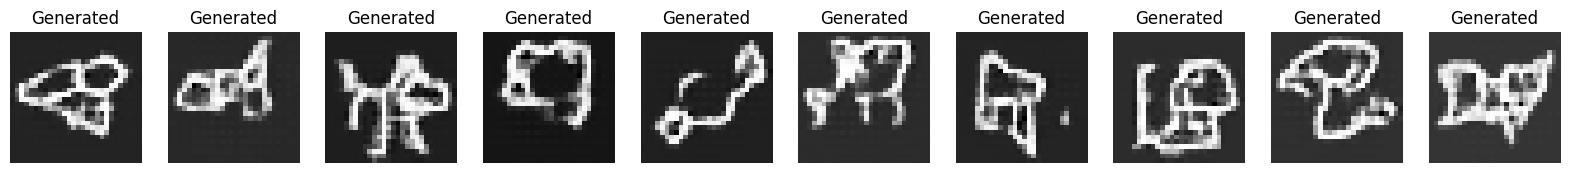

In [26]:
LATENT_DIM_GAN = 64
def generate_images(generator, n=10, latent_dim=LATENT_DIM_GAN):
    """Generates new images by sampling from the latent space."""

    with torch.no_grad():  # Disable gradient calculations
        # Sample random noise vectors
        noise = torch.randn(n, latent_dim)

        # Generate images
        generated_images = generator(noise)

    # Rescale images from [-1, 1] to [0, 1] (if you used tanh activation)
    generated_images = 0.5 * generated_images + 0.5

    # Plot the images
    fig, axes = plt.subplots(nrows=1, ncols=n, figsize=(20, 2))
    for i, image in enumerate(generated_images):
        ax = plt.subplot(1, n, i + 1)
        plt.imshow(image.squeeze().detach().numpy(), cmap='gray')  # Convert to NumPy and remove channel dimension
        plt.title("Generated")
        plt.axis("off")
    plt.show()

# Generate 10 images
generate_images(generator, n=10)

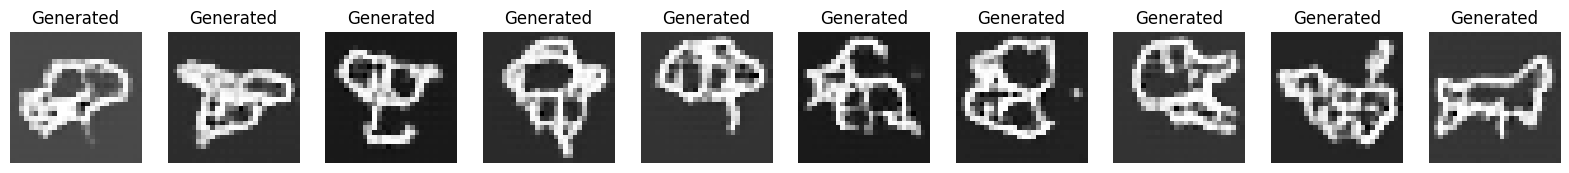

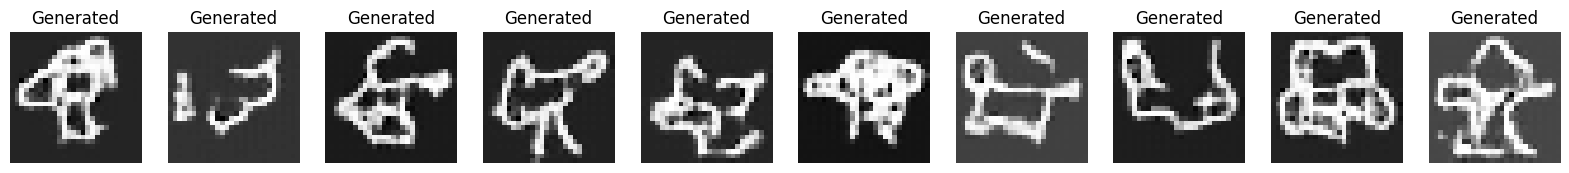

In [16]:
# Define 2 different latent dimensions
LATENT_DIM_GAN1 = 64
LATENT_DIM_GAN2 = 128

# Create 2 generators with different latent_dim
generator1 = Generator(latent_dim=LATENT_DIM_GAN1)
generator2 = Generator(latent_dim=LATENT_DIM_GAN2)

# Load weights
generator1.load_state_dict(torch.load("gan/improved_gan_generator_11epoches_500000datasets.h5"))
generator2.load_state_dict(torch.load("gan/improved_gan_generator_1000epoches_15000datasets.h5"))

# Switch to evaluation mode
generator1.eval()
generator2.eval()

# Create separate noise vectors for each generator
noise1 = torch.randn(10, LATENT_DIM_GAN1, device=device)
noise2 = torch.randn(10, LATENT_DIM_GAN2, device=device)

# Generate images
generate_images(generator1, n=10, latent_dim=LATENT_DIM_GAN1)
generate_images(generator2, n=10, latent_dim=LATENT_DIM_GAN2)


In [17]:
import torch
import torch_fidelity
import os
from torchvision.utils import save_image

# Create directories to save images
os.makedirs("gan/gan/generated_images_model_1", exist_ok=True)
os.makedirs("gan/generated_images_model_2", exist_ok=True)

# Generate images from generator 1
noise1 = torch.randn(1000, LATENT_DIM_GAN1)  # Generate more images for better evaluation
with torch.no_grad():
    fake_images1 = generator1(noise1)
    # Save each image to directory
    for i, img in enumerate(fake_images1):
        save_image(img, f"gan/generated_images_model_1/image_{i}.png")

# Generate images from generator 2  
noise2 = torch.randn(1000, LATENT_DIM_GAN2)
with torch.no_grad():
    fake_images2 = generator2(noise2)
    for i, img in enumerate(fake_images2):
        save_image(img, f"gan/generated_images_model_2/image_{i}.png")

# Calculate FID score
metrics = torch_fidelity.calculate_metrics(
    input1="gan/generated_images_model_1",
    input2="gan/generated_images_model_2", 
    cuda=False,  # Use CPU
    fid=True,
    verbose=False
)

print(f"FID score between two generators: {metrics['frechet_inception_distance']:.2f}")

Downloading: "https://github.com/toshas/torch-fidelity/releases/download/v0.2.0/weights-inception-2015-12-05-6726825d.pth" to /Users/minh/.cache/torch/hub/checkpoints/weights-inception-2015-12-05-6726825d.pth
100%|██████████| 91.2M/91.2M [00:08<00:00, 11.9MB/s]


FID score between generators: 11.31


In [20]:
import torch
import torch_fidelity
import os
from torchvision.utils import save_image
from torch.utils.data import DataLoader, TensorDataset

# Create directories for generated and real images
os.makedirs("gan/generated_images_model_1", exist_ok=True)
os.makedirs("gan/generated_images_model_2", exist_ok=True)
os.makedirs("gan/real_images", exist_ok=True)

# Save real images
def save_real_images(data_loader, num_images=1000):
    count = 0
    for images, _ in data_loader:
        if count >= num_images:
            break
        for img in images:
            save_image(img, f"gan/real_images/real_{count}.png")
            count += 1
            if count >= num_images:
                break

# Generate and save images from generator 1
noise1 = torch.randn(1000, LATENT_DIM_GAN1)
with torch.no_grad():
    fake_images1 = generator1(noise1)
    for i, img in enumerate(fake_images1):
        save_image(img, f"gan/generated_images_model_1/image_{i}.png")

# Generate and save images from generator 2
noise2 = torch.randn(1000, LATENT_DIM_GAN2)
with torch.no_grad():
    fake_images2 = generator2(noise2)
    for i, img in enumerate(fake_images2):
        save_image(img, f"gan/generated_images_model_2/image_{i}.png")

# Save real images
save_real_images(train_loader)

# Calculate FID scores
fid_score1 = torch_fidelity.calculate_metrics(
    input1="gan/generated_images_model_1",
    input2="gan/real_images",
    cuda=False,
    fid=True,
    verbose=False
)

fid_score2 = torch_fidelity.calculate_metrics(
    input1="gan/generated_images_model_2",
    input2="gan/real_images",
    cuda=False,
    fid=True,
    verbose=False
)

print(f"FID score for Generator 1 vs Real Images: {fid_score1['frechet_inception_distance']:.2f}")
print(f"FID score for Generator 2 vs Real Images: {fid_score2['frechet_inception_distance']:.2f}")


FID score for Generator 1 vs Real Images: 49.33
FID score for Generator 2 vs Real Images: 45.52


While both generators were evaluated, **Generator 2** demonstrated superior performance based on a combination of quantitative and qualitative assessments. Quantitatively, Generator 2 achieved a lower, and thus better, **Fréchet Inception Distance (FID) score of 45.52** compared to Generator 1's score of 49.33. Qualitatively, the images generated by Generator 2 were observed to be visually clearer, more diverse, and more closely resembled the target classes from the Quick, Draw! dataset. Therefore, based on both the FID score and visual inspection, Generator 2 is selected as the best GAN model for this project. [Link to model best-gan-model.h5](./best-gan-model.h5)

/var/folders/r4/752pqpt90zxczqv7ghd87g7m0000gp/T/ipykernel_71089/2625571589.py:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  generator_best.load_state_dict(torch.load("be

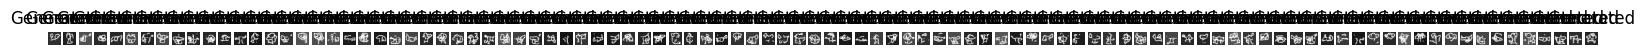

In [28]:
LATENT_DIM_GAN = 128
# Create a generator instance
generator_best = Generator(latent_dim=LATENT_DIM_GAN2)

# Load the saved weights
generator_best.load_state_dict(torch.load("best-gan-model.h5"))

# Put the generator in evaluation mode (important for layers like BatchNorm)
generator_best.eval()

generate_images(generator_best, n=100)
generate_images(generator_best, n=100, latent_dim=LATENT_DIM_GAN1)


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import time
import os
import urllib.request
from tqdm import tqdm

# Constants
IMAGE_SIZE = 28
CHANNELS = 1
BATCH_SIZE = 256
LATENT_DIM = 128
LATENT_DIM_GAN = 64
EPOCHS = 1000
CLASSES = ['cat', 'dog', 'bird', 'tree', 'house']
DATA_DIR = "quickdraw_data"
MAX_ITEMS_PER_CLASS = 100000
IMAGE_SAVE_DIR = "gan/image/v1_4"

# Set random seed
torch.manual_seed(42)
np.random.seed(42)

In [ ]:
def download_quickdraw_data(classes, base_url="https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/"):
    os.makedirs(DATA_DIR, exist_ok=True)
    for class_name in classes:
        file_name = f"{class_name.replace(' ', '_')}.npy"
        file_path = os.path.join(DATA_DIR, file_name)
        if not os.path.exists(file_path):
            print(f"Downloading {file_name}...")
            with tqdm(unit="B", unit_scale=True, unit_divisor=1024, miniters=1) as t:
                urllib.request.urlretrieve(base_url + file_name, file_path, 
                    reporthook=lambda b, bsize, tsize: t.update(bsize))
        else:
            print(f"{file_name} already downloaded.")

def load_quickdraw_data(classes, max_items_per_class, data_dir=DATA_DIR):
    all_data = []
    all_labels = []
    for idx, class_name in enumerate(classes):
        file_name = f"{class_name.replace(' ', '_')}.npy"
        file_path = os.path.join(data_dir, file_name)
        try:
            data = np.load(file_path)
            if data.shape[0] > max_items_per_class:
                data = data[:max_items_per_class]
            all_data.append(data)
            all_labels.append(np.full((data.shape[0],), idx))
        except FileNotFoundError:
            print(f"Error: File not found: {file_path}")
            return None, None
    return np.concatenate(all_data), np.concatenate(all_labels)

**Generate and Save Images Function**
- Generating sample images from random noise at regular intervals during training
- Providing a chronological record of how image generation improves across epochs

In [ ]:
def generate_and_save_images(generator, epoch, batch_idx, noise, save_dir):
    """Generates and saves images from the generator with larger size and higher quality."""
    os.makedirs(save_dir, exist_ok=True)

    with torch.no_grad():
        fake_images = generator(noise).detach().cpu()
        
        # Rescale images from [-1, 1] to [0, 1]
        fake_images = 0.5 * fake_images + 0.5

        # Save image grid with large size
        fig = plt.figure(figsize=(10, 10))
        for i in range(fake_images.size(0)):
            plt.subplot(4, 4, i + 1)  # 4x4 grid for 16 images
            plt.imshow(fake_images[i, 0, :, :], cmap='gray')
            plt.axis('off')

        plt.tight_layout()
        plt.savefig(
            f"{save_dir}/epoch_{epoch}_batch_{batch_idx}.png",
            dpi=300,  # Increase resolution
            bbox_inches='tight',
            pad_inches=0.1
        )
        plt.close(fig)

In [ ]:
class EarlyStopping:
    def __init__(self, patience=7, min_delta=0.001, verbose=True):
        self.patience = patience
        self.min_delta = min_delta
        self.verbose = verbose
        self.counter = 0
        self.best_g_loss = float('inf')
        self.best_d_loss = float('inf')
        self.early_stop = False
        
    def __call__(self, g_loss, d_loss):
        improved = False
        if g_loss < self.best_g_loss - self.min_delta:
            self.best_g_loss = g_loss
            improved = True
        if d_loss < self.best_d_loss - self.min_delta:
            self.best_d_loss = d_loss
            improved = True
        if not improved:
            self.counter += 1
            if self.verbose:
                print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.counter = 0

**Device Setup for M1 Macbook Air 2020 (Apple Silicon)**:

Using Metal Performance Shaders (MPS) backend for GPU acceleration on M1 Mac:

In [ ]:
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
print(f"Using device: {device}")

Using device: mps


In [ ]:
class Generator(nn.Module):
    def __init__(self, latent_dim=128):
        super(Generator, self).__init__()
        self.linear = nn.Sequential(
            nn.Linear(latent_dim, 7 * 7 * 256),
            nn.LeakyReLU(0.2)
        )
        self.conv_layers = nn.Sequential(
            nn.ConvTranspose2d(256, 128, 4, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2),
            nn.ConvTranspose2d(128, 64, 4, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2),
            nn.Conv2d(64, 1, 3, stride=1, padding=1),
            nn.Tanh()
        )

    def forward(self, z):
        x = self.linear(z)
        x = x.view(-1, 256, 7, 7)
        img = self.conv_layers(x)
        return img

In [ ]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Conv2d(1, 64, 3, stride=2, padding=1),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.Conv2d(64, 128, 3, stride=2, padding=1),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.Flatten(),
            nn.Linear(7 * 7 * 128, 1),
            nn.Sigmoid()
        )

    def forward(self, img):
        validity = self.model(img)
        return validity

Epoch [0/1000] Batch [0/1563] D_loss: 1.3902 G_loss: 0.6990
Epoch [0/1000] Batch [100/1563] D_loss: 1.3172 G_loss: 0.7025
Epoch [0/1000] Batch [200/1563] D_loss: 1.3413 G_loss: 0.7268
Epoch [0/1000] Batch [300/1563] D_loss: 1.1884 G_loss: 0.8380
Epoch [0/1000] Batch [400/1563] D_loss: 1.0257 G_loss: 0.9524
Epoch [0/1000] Batch [500/1563] D_loss: 0.9709 G_loss: 1.2996
Epoch [0/1000] Batch [600/1563] D_loss: 0.8381 G_loss: 1.2482
Epoch [0/1000] Batch [700/1563] D_loss: 0.7265 G_loss: 1.4778
Epoch [0/1000] Batch [800/1563] D_loss: 0.7899 G_loss: 1.2187
Epoch [0/1000] Batch [900/1563] D_loss: 0.6922 G_loss: 1.8963
Epoch [0/1000] Batch [1000/1563] D_loss: 0.7095 G_loss: 1.3225
Epoch [0/1000] Batch [1100/1563] D_loss: 0.7776 G_loss: 1.8999
Epoch [0/1000] Batch [1200/1563] D_loss: 0.7489 G_loss: 2.1431
Epoch [0/1000] Batch [1300/1563] D_loss: 0.5498 G_loss: 1.7522
Epoch [0/1000] Batch [1400/1563] D_loss: 0.5736 G_loss: 1.6354
Epoch [0/1000] Batch [1500/1563] D_loss: 0.7408 G_loss: 1.8193
Epoc

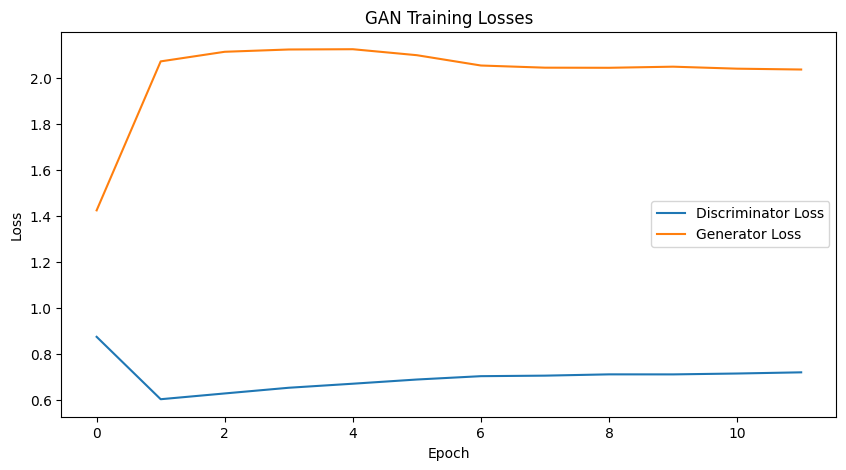

In [ ]:
# Download and load data
x_data, labels = load_quickdraw_data(CLASSES, MAX_ITEMS_PER_CLASS)

if x_data is not None and labels is not None:
    # Prepare data
    x_data = x_data.reshape(-1, 1, 28, 28).astype('float32') / 255.
    
    # Split train/test
    train_size = int(0.8 * len(x_data))
    x_train = torch.from_numpy(x_data[:train_size]).float()
    y_train = torch.from_numpy(labels[:train_size]).long()
    
    # Create DataLoader
    train_dataset = TensorDataset(x_train, y_train)
    train_loader = DataLoader(
        train_dataset,
        batch_size=BATCH_SIZE,
        shuffle=True,
        num_workers=2,
        pin_memory=True
    )

    # Initialize models
    generator = Generator(LATENT_DIM_GAN).to(device)
    discriminator = Discriminator().to(device)

    # Optimizers
    optimizer_G = optim.Adam(generator.parameters(), lr=0.0002, betas=(0.5, 0.999))
    optimizer_D = optim.Adam(discriminator.parameters(), lr=0.0002, betas=(0.5, 0.999))
    criterion = nn.BCELoss()

    # Early stopping
    early_stopping = EarlyStopping(patience=10)

    # Training
    start_time = time.time()
    d_losses = []
    g_losses = []

    for epoch in range(EPOCHS):
        epoch_d_losses = []
        epoch_g_losses = []
        
        for batch_idx, (real_images, _) in enumerate(train_loader):
            batch_size = real_images.size(0)
            real_images = real_images.to(device)

            # Train Discriminator
            optimizer_D.zero_grad()
            label_real = torch.ones(batch_size, 1).to(device)
            label_fake = torch.zeros(batch_size, 1).to(device)
            
            output_real = discriminator(real_images)
            d_loss_real = criterion(output_real, label_real)
            
            noise = torch.randn(batch_size, LATENT_DIM_GAN).to(device)
            fake_images = generator(noise)
            output_fake = discriminator(fake_images.detach())
            d_loss_fake = criterion(output_fake, label_fake)
            
            d_loss = d_loss_real + d_loss_fake
            d_loss.backward()
            optimizer_D.step()

            # Train Generator
            optimizer_G.zero_grad()
            output_fake = discriminator(fake_images)
            g_loss = criterion(output_fake, label_real)
            g_loss.backward()
            optimizer_G.step()

            epoch_d_losses.append(d_loss.item())
            epoch_g_losses.append(g_loss.item())

            if batch_idx % 100 == 0:
                generate_and_save_images(
                    generator,
                    epoch,
                    batch_idx,
                    noise[:16],
                    save_dir=IMAGE_SAVE_DIR
                )
                print(f'Epoch [{epoch}/{EPOCHS}] Batch [{batch_idx}/{len(train_loader)}] '
                        f'D_loss: {d_loss.item():.4f} G_loss: {g_loss.item():.4f}')

        # Calculate average losses
        avg_d_loss = sum(epoch_d_losses) / len(epoch_d_losses)
        avg_g_loss = sum(epoch_g_losses) / len(epoch_g_losses)
        d_losses.append(avg_d_loss)
        g_losses.append(avg_g_loss)

        # Early stopping check
        early_stopping(avg_g_loss, avg_d_loss)
        if early_stopping.early_stop:
            print("Early stopping triggered")
            break

    end_time = time.time()
    print(f"Total training time: {end_time - start_time:.2f} seconds")

    # Save model
    torch.save(generator.state_dict(), "improved_gan_generator.h5")
    print("Improved GAN generator saved as improved_gan_generator.h5")

    # Plot losses
    plt.figure(figsize=(10, 5))
    plt.plot(d_losses, label='Discriminator Loss')
    plt.plot(g_losses, label='Generator Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('GAN Training Losses')
    plt.legend()
    plt.show()

In [ ]:
# Create a generator instance
generator = Generator(latent_dim=LATENT_DIM_GAN)

# Load the saved weights
generator.load_state_dict(torch.load("improved_gan_generator_1_4.h5"))

# Put the generator in evaluation mode (important for layers like BatchNorm)
generator.eval()

/var/folders/r4/752pqpt90zxczqv7ghd87g7m0000gp/T/ipykernel_71089/1423882043.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  generator.load_state_dict(torch.load("improve

Generator(
  (linear): Sequential(
    (0): Linear(in_features=64, out_features=12544, bias=True)
    (1): LeakyReLU(negative_slope=0.2)
  )
  (conv_layers): Sequential(
    (0): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2)
    (3): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): LeakyReLU(negative_slope=0.2)
    (6): Conv2d(64, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): Tanh()
  )
)

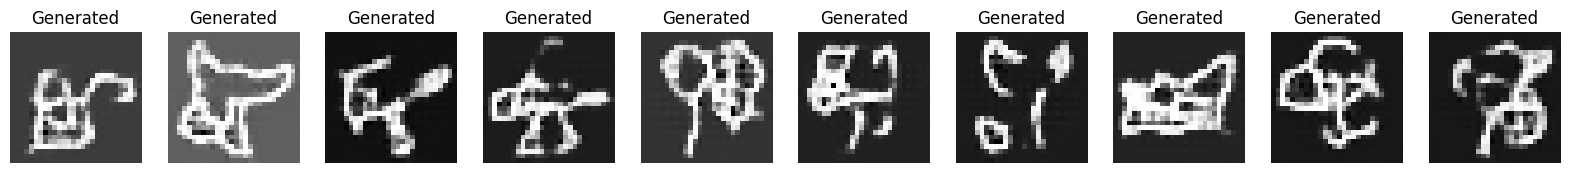

In [ ]:
LATENT_DIM_GAN = 64
def generate_images(generator, n=10, latent_dim=LATENT_DIM_GAN):
    """Generates new images by sampling from the latent space."""

    with torch.no_grad():  # Disable gradient calculations
        # Sample random noise vectors
        noise = torch.randn(n, latent_dim)

        # Generate images
        generated_images = generator(noise)

    # Rescale images from [-1, 1] to [0, 1] (if you used tanh activation)
    generated_images = 0.5 * generated_images + 0.5

    # Plot the images
    fig, axes = plt.subplots(nrows=1, ncols=n, figsize=(20, 2))
    for i, image in enumerate(generated_images):
        ax = plt.subplot(1, n, i + 1)
        plt.imshow(image.squeeze().detach().numpy(), cmap='gray')  # Convert to NumPy and remove channel dimension
        plt.title("Generated")
        plt.axis("off")
    plt.show()

# Generate 10 images
generate_images(generator, n=10)

/var/folders/r4/752pqpt90zxczqv7ghd87g7m0000gp/T/ipykernel_71089/1795812075.py:10: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  generator1.load_state_dict(torch.load("impro

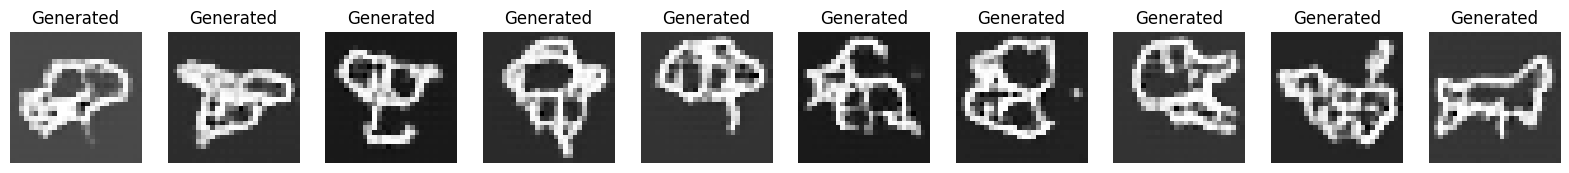

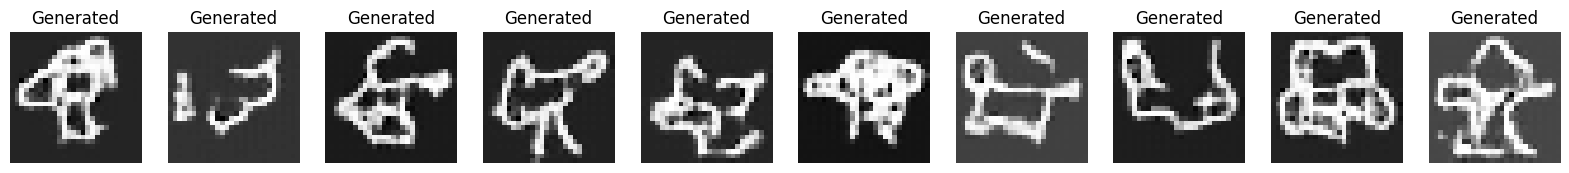

In [ ]:
# Định nghĩa 2 latent dimensions khác nhau
LATENT_DIM_GAN1 = 64
LATENT_DIM_GAN2 = 128

# Tạo 2 generator với latent_dim khác nhau
generator1 = Generator(latent_dim=LATENT_DIM_GAN1)
generator2 = Generator(latent_dim=LATENT_DIM_GAN2)

# Load trọng số
generator1.load_state_dict(torch.load("improved_gan_generator_1_4.h5"))
generator2.load_state_dict(torch.load("gan/improved_gan_generator_1000epoches_15000datasets.h5"))

# Chuyển sang chế độ evaluation
generator1.eval()
generator2.eval()

# Tạo noise vector riêng cho từng generator
noise1 = torch.randn(10, LATENT_DIM_GAN1, device=device)
noise2 = torch.randn(10, LATENT_DIM_GAN2, device=device)

# Generate images
generate_images(generator1, n=10, latent_dim=LATENT_DIM_GAN1)
generate_images(generator2, n=10, latent_dim=LATENT_DIM_GAN2)


In [ ]:
import torch
import torch_fidelity
import os
from torchvision.utils import save_image

# Tạo thư mục để lưu ảnh
os.makedirs("generated_images_model_1", exist_ok=True)
os.makedirs("generated_images_model_2", exist_ok=True)

# Sinh ảnh từ generator 1
noise1 = torch.randn(1000, LATENT_DIM_GAN1)  # Sinh nhiều ảnh hơn để đánh giá tốt hơn
with torch.no_grad():
    fake_images1 = generator1(noise1)
    # Lưu từng ảnh vào thư mục
    for i, img in enumerate(fake_images1):
        save_image(img, f"generated_images_model_1/image_{i}.png")

# Sinh ảnh từ generator 2
noise2 = torch.randn(1000, LATENT_DIM_GAN2)
with torch.no_grad():
    fake_images2 = generator2(noise2)
    for i, img in enumerate(fake_images2):
        save_image(img, f"generated_images_model_2/image_{i}.png")

# Tính FID score
metrics = torch_fidelity.calculate_metrics(
    input1="generated_images_model_1",
    input2="generated_images_model_2",
    cuda=False,  # Sử dụng CPU
    fid=True,
    verbose=False
)

print(f"FID score giữa hai generator: {metrics['frechet_inception_distance']:.2f}")

Downloading: "https://github.com/toshas/torch-fidelity/releases/download/v0.2.0/weights-inception-2015-12-05-6726825d.pth" to /Users/minh/.cache/torch/hub/checkpoints/weights-inception-2015-12-05-6726825d.pth
100%|██████████| 91.2M/91.2M [00:08<00:00, 11.9MB/s]
/Users/minh/Codespace/github/quickdraw-gan-vae/venv/lib/python3.9/site-packages/torch_fidelity/datasets.py:16: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  img = torch.ByteTensor(torch.ByteStorage.from_buffer(img.tobytes())).view(height, width, 3)
/Users/minh/Codespace/github/quickdraw-gan-vae/venv/lib/python3.9/site-packages/torch_fidelity/datasets.py:16: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should 

FID score giữa hai generator: 11.31
